<a href="https://colab.research.google.com/github/eridanirojas/563-rojas/blob/main/3DMCSampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo Sampling Project for MSE 563
# Summary: This project aims to simulate a Markovian-Chain Metroplis Monte Carlo simulation in 3 dimensions, using the Lennard Jones potential
# to calculate pairwise potentials. The goal is to see the overall performance of this model, including equilibration times, accuracy, runtimes,
# and output ensemble.


In [112]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import math
import time
import copy

# Lennard Jonesium , sigma = 1.0, epsilon = 1.0

In [2]:
# Initialize system
class System():
  def __init__(self,N,L,T, r_min):
    self.V = L**3
    self.L = L
    self.N = N
    self.T = T
    self.particles = self.fill_system(N, L, r_min)  # Ensure spacing

  def fill_system(self, N, L, r_min=1.0):
    # Stops two particles overlapping
    particles = []
    while len(particles) < N:
      new_particle = L * np.random.rand(3)
      too_close = False

      for p in particles: # Checking spacing
        r = self.distance(new_particle,p)
        if r < r_min:
          too_close = True
          break

      if not too_close: # If spacing is good, add it
        particles.append(new_particle)

    return np.array(particles)

  def compute_energy(self, ideal_gas = False, epsilon = 1.0, sigma = 1.0, r_cut = 2.5):
    # To calculate energy of a system
    energy_sum = 0.0
    pairs = 0
    virial_sum = 0.0
    if ideal_gas is True: # If system behaves as an ideal gas, there can be no interactions
      pressure = (self.N * self.T / self.V)
      return energy_sum, pairs, pressure # energy, pairs, and pressure
    for i in range(self.N - 1):
        for j in range(i + 1, self.N):
            e, v = self.LJ_potential(self.particles[i], self.particles[j], epsilon, sigma, r_cut)
            energy_sum += e
            virial_sum += v
            if not np.isclose(e, 0.0):
                pairs += 1
    pressure = (self.N * self.T / self.V) + (virial_sum / (3 * self.V))
    return energy_sum, pairs, pressure # energy, pairs, and pressure

  def distance(self, particle1, particle2):
    # Distance between two particles considering PBCs

    # Displacement vector
    delta = particle2 - particle1

    # Shifting to be between -L/2 and L/2
    delta -= np.round(delta / self.L) * self.L

    # Distance
    r = np.linalg.norm(delta)

    return r

  def LJ_potential(self, particle1, particle2, epsilon, sigma, r_cut):
    # LJ potential and virial theorem

    # Getting distance with PBCs in mind
    r = self.distance(particle1, particle2)
    if r > r_cut:
      return 0.0, 0.0

    # Handling overlaps
    if np.isclose(r, 0.0):
      print("too close")
      return np.inf, np.inf

    # Compute LJ potential
    sr6 = (sigma / r) ** 6
    sr12 = sr6 * sr6

    # Lennard-Jones Force
    F_LJ = 24.0 * epsilon * (2 * sr12 - sr6) / r

    # Virial summation contribution: r * F
    v = r * F_LJ

    return 4.0 * epsilon * (sr12 - sr6), v

  def plot(self, particles, L, title = "Current configuration"):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(particles[:,0], particles[:,1], particles[:,2], c='blue', marker='o')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_zlim(0, L)
    plt.title(title)
    plt.show()

# Simulation implementation

In [3]:
# Monte Carlo Simulation, with Markov-Chain implementation and with delta as a step size, from Frenkel and Smit

def simulation(system, steps, T=1.0, delta = 1.0, epsilon = 1.0, sigma = 1.0, r_cut = 2.5, ideal_gas = False):
    # Making a copy to not disturb initial configuration
    sim_system = copy.deepcopy(system)

    # Calculate initial energy and initial virial sum
    energy, pairs, pressure = sim_system.compute_energy(ideal_gas, epsilon, sigma, r_cut)

    # Pressure list
    pressures = [pressure]
    # Energy list
    energies = [energy]

    # Configuration list
    configs = [copy.deepcopy(sim_system.particles)]

    # Initialize accepted and rejected tally
    accepted = 0
    rejected = 0

    for step in range(steps):
        # Pick a random particle
        i = np.random.randint(sim_system.N)

        # Store initial position
        initial_pos = sim_system.particles[i].copy()

        # Compute initial energy of system
        E_initial, _, P_initial = sim_system.compute_energy(ideal_gas, epsilon, sigma, r_cut)

        # Propose a move using step size factor delta
        displacement = (np.random.rand(3) - 0.5) * delta
        sim_system.particles[i] += displacement

        # PBCs, if applicable to displacement
        sim_system.particles[i] %= sim_system.L

        # Compute final energy and pressure
        E_final, _, P_final = sim_system.compute_energy(ideal_gas, epsilon, sigma, r_cut)
        dE = E_final - E_initial

        # Metropolis criteria
        if np.random.rand() < np.exp(-dE/T):
            accepted += 1
            energy = E_final # Accept the move
            pressure = P_final
        else:
            sim_system.particles[i] = initial_pos # Reject the move
            rejected += 1
            energy = E_initial
            pressure = P_initial

        energies.append(energy) # Energy history
        configs.append(copy.deepcopy(sim_system.particles)) # Configuration history
        pressures.append(pressure) # Pressure history

    return np.array(energies), accepted, rejected, configs, pressures

In [4]:
def autocorr1D(array):
  ft = np.fft.rfft(array - np.average(array))
  acorr = np.fft.irfft(ft * np.conjugate(ft)) / (len(array) * np.var(array))
  dt = np.where(acorr<0)[0][0]
  nsamples = len(array)//dt
  acorr = acorr[dt:nsamples]
  #return acorr[0 : len(acorr) // 2]
  return nsamples, dt


## N/V = 0.7, 0.5 with T = 0.5, 2.0. Simulation blocks

In [44]:
N = [19, 14]
L = 3
T = [0.5, 2.00]

In [45]:
l_energies = []
a_rates = []

In [46]:
for i in N:
  for j in T:
    if j == 0.5:
      delt = 1.0
      steps = 10000
    else:
      delt = 0.3
      steps = 5000
    t1 = time.perf_counter()
    system = System(i,L,j, r_min = 1)
    energies, accepted, rejected, _ , _ = simulation(system, steps, T = j, delta = delt, epsilon = 1.0, sigma = 1.0, r_cut = 2.5)
    t2 = time.perf_counter()
    l_energies.append(energies)
    a_rates.append(accepted/(accepted+rejected))
    print(f"N = {i}, T={j} simulation complete taking {t2-t1} seconds, with {len(energies)/(t2-t1)} samples per second")

N = 19, T=0.5 simulation complete taking 41.74857137000026 seconds, with 239.5531073713945 samples per second
N = 19, T=2.0 simulation complete taking 25.736658069999976 seconds, with 194.31427290979295 samples per second
N = 14, T=0.5 simulation complete taking 19.45951422799999 seconds, with 513.9388312997926 samples per second
N = 14, T=2.0 simulation complete taking 9.681177371000103 seconds, with 516.5694014635512 samples per second


## Average energy per particle for N/V = 0.7, T = 0.5

In [55]:
for start in range(0,10000,100):
  print(start, autocorr1D(l_energies[0][start:]))

0 (np.int64(10), np.int64(964))
100 (np.int64(10), np.int64(944))
200 (np.int64(10), np.int64(929))
300 (np.int64(10), np.int64(908))
400 (np.int64(10), np.int64(897))
500 (np.int64(10), np.int64(882))
600 (np.int64(10), np.int64(858))
700 (np.int64(11), np.int64(826))
800 (np.int64(11), np.int64(789))
900 (np.int64(12), np.int64(753))
1000 (np.int64(12), np.int64(728))
1100 (np.int64(12), np.int64(712))
1200 (np.int64(12), np.int64(694))
1300 (np.int64(12), np.int64(683))
1400 (np.int64(12), np.int64(679))
1500 (np.int64(12), np.int64(699))
1600 (np.int64(11), np.int64(704))
1700 (np.int64(12), np.int64(688))
1800 (np.int64(12), np.int64(673))
1900 (np.int64(12), np.int64(672))
2000 (np.int64(11), np.int64(671))
2100 (np.int64(11), np.int64(661))
2200 (np.int64(11), np.int64(651))
2300 (np.int64(11), np.int64(644))
2400 (np.int64(11), np.int64(636))
2500 (np.int64(11), np.int64(628))
2600 (np.int64(11), np.int64(626))
2700 (np.int64(11), np.int64(627))
2800 (np.int64(11), np.int64(625

In [64]:
autocorr1D(l_energies[0][9500:]) # 21 independent samples

(np.int64(21), np.int64(23))

In [113]:
print("<E>/N for N/V = 0.7, T = 0.5:", np.average(l_energies[0][9500:])/ N[0])
print("stD(E)/N for N/V = 0.7, T = 0.5:", np.std(l_energies[0][9500:])/ N[0])

<E>/N for N/V = 0.7, T = 0.5: -4.248552598305875
stD(E)/N for N/V = 0.7, T = 0.5: 0.033873040894168545


Text(0.5, 1.0, 'Average energy per particle with N/V = 0.7, T = 0.5')

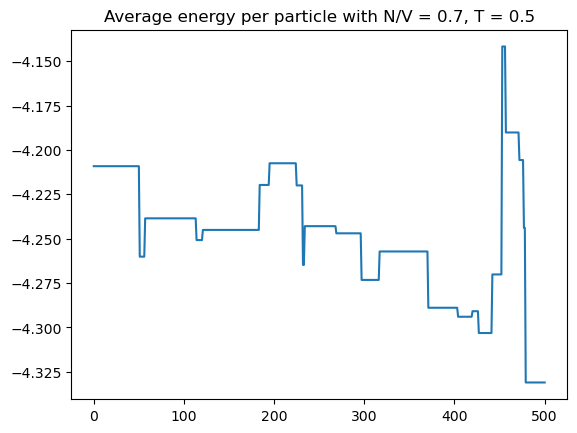

In [110]:
plt.plot(l_energies[0][9500:]/N[0])
plt.title("Average energy per particle with N/V = 0.7, T = 0.5")

## Average energy per particle for N/V 0.7, T = 2.0

In [69]:
for start in range(0,5000,100):
  print(start, autocorr1D(l_energies[1][start:]))

0 (np.int64(25), np.int64(198))
100 (np.int64(25), np.int64(192))
200 (np.int64(24), np.int64(194))
300 (np.int64(24), np.int64(193))
400 (np.int64(22), np.int64(204))
500 (np.int64(22), np.int64(197))
600 (np.int64(22), np.int64(194))
700 (np.int64(22), np.int64(193))
800 (np.int64(21), np.int64(194))
900 (np.int64(21), np.int64(190))
1000 (np.int64(20), np.int64(199))
1100 (np.int64(19), np.int64(197))
1200 (np.int64(19), np.int64(198))
1300 (np.int64(18), np.int64(205))
1400 (np.int64(18), np.int64(194))
1500 (np.int64(16), np.int64(206))
1600 (np.int64(17), np.int64(197))
1700 (np.int64(16), np.int64(197))
1800 (np.int64(16), np.int64(198))
1900 (np.int64(16), np.int64(190))
2000 (np.int64(16), np.int64(181))
2100 (np.int64(16), np.int64(181))
2200 (np.int64(13), np.int64(205))
2300 (np.int64(11), np.int64(237))
2400 (np.int64(12), np.int64(209))
2500 (np.int64(13), np.int64(191))
2600 (np.int64(14), np.int64(167))
2700 (np.int64(13), np.int64(168))
2800 (np.int64(13), np.int64(168

In [71]:
autocorr1D(l_energies[1][1000:]) # 20 independent samples

(np.int64(20), np.int64(199))

In [114]:
print("<E>/N for N/V = 0.7, T = 2.0:", np.average(l_energies[1][1000:])/ N[0])
print("stD(E)/N for N/V = 0.7, T = 2.0:", np.std(l_energies[1][1000:])/ N[0])

<E>/N for N/V = 0.7, T = 2.0: -3.4043788138026305
stD(E)/N for N/V = 0.7, T = 2.0: 0.3299616237040115


Text(0.5, 1.0, 'Average energy per particle with N/V = 0.7, T = 2.0')

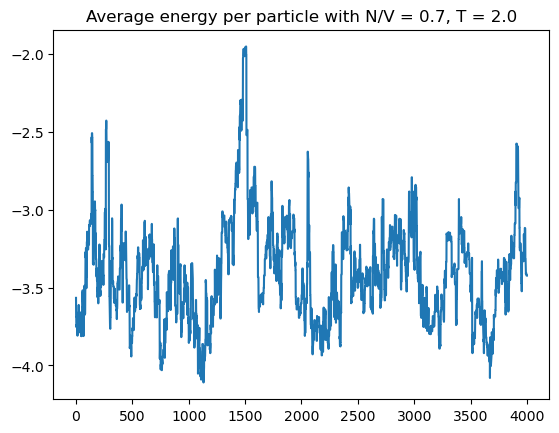

In [109]:
plt.plot(l_energies[1][1000:]/N[0])
plt.title("Average energy per particle with N/V = 0.7, T = 2.0")

## N/V = 0.5, T = 0.5, Average energy per particle

In [75]:
for start in range(0,10000,100):
  print(start, autocorr1D(l_energies[2][start:]))

0 (np.int64(9), np.int64(1036))
100 (np.int64(9), np.int64(1019))
200 (np.int64(9), np.int64(1032))
300 (np.int64(9), np.int64(1046))
400 (np.int64(8), np.int64(1067))
500 (np.int64(8), np.int64(1076))
600 (np.int64(8), np.int64(1089))
700 (np.int64(8), np.int64(1105))
800 (np.int64(6), np.int64(1500))
900 (np.int64(6), np.int64(1488))
1000 (np.int64(6), np.int64(1423))
1100 (np.int64(6), np.int64(1432))
1200 (np.int64(6), np.int64(1416))
1300 (np.int64(7), np.int64(1128))
1400 (np.int64(6), np.int64(1258))
1500 (np.int64(7), np.int64(1105))
1600 (np.int64(7), np.int64(1081))
1700 (np.int64(7), np.int64(1055))
1800 (np.int64(7), np.int64(1034))
1900 (np.int64(7), np.int64(1031))
2000 (np.int64(7), np.int64(1026))
2100 (np.int64(7), np.int64(1009))
2200 (np.int64(7), np.int64(1008))
2300 (np.int64(7), np.int64(1025))
2400 (np.int64(7), np.int64(1025))
2500 (np.int64(7), np.int64(1031))
2600 (np.int64(7), np.int64(1029))
2700 (np.int64(7), np.int64(1027))
2800 (np.int64(6), np.int64(1034

In [80]:
autocorr1D(l_energies[2][5000:]) 
# 13 independent samples, which is unfortunately the most amount of independent samples I've seen for N/V 0.5, T = 0.5

(np.int64(13), np.int64(371))

In [115]:
print("<E>/N for N/V = 0.5, T = 0.5:", np.average(l_energies[2][5000:])/ N[1])
print("stD(E)/N for N/V = 0.5, T = 0.5:", np.std(l_energies[2][5000:])/ N[1])

<E>/N for N/V = 0.5, T = 0.5: -3.0787019967015534
stD(E)/N for N/V = 0.5, T = 0.5: 0.11583467244479746


Text(0.5, 1.0, 'Average energy per particle with N/V = 0.5, T = 0.5')

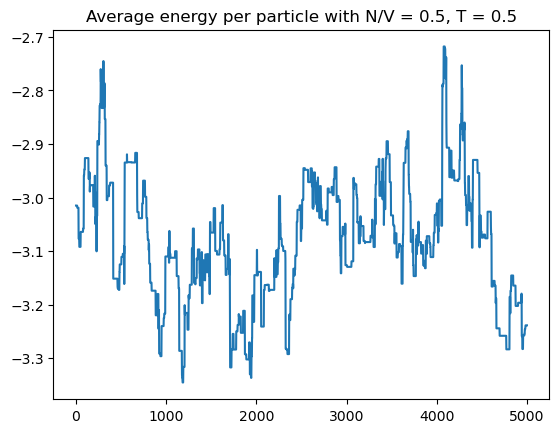

In [108]:
plt.plot(l_energies[2][5000:]/N[1])
plt.title("Average energy per particle with N/V = 0.5, T = 0.5")

## N/V = 0.5, T = 2.0, Average energy per particle

In [93]:
for start in range(0,5000,100):
  print(start, autocorr1D(l_energies[3][start:]))

0 (np.int64(37), np.int64(134))
100 (np.int64(37), np.int64(132))
200 (np.int64(36), np.int64(131))
300 (np.int64(35), np.int64(132))
400 (np.int64(34), np.int64(135))
500 (np.int64(18), np.int64(244))
600 (np.int64(32), np.int64(137))
700 (np.int64(16), np.int64(258))
800 (np.int64(17), np.int64(245))
900 (np.int64(16), np.int64(249))
1000 (np.int64(16), np.int64(240))
1100 (np.int64(16), np.int64(242))
1200 (np.int64(8), np.int64(429))
1300 (np.int64(8), np.int64(438))
1400 (np.int64(14), np.int64(243))
1500 (np.int64(14), np.int64(245))
1600 (np.int64(17), np.int64(195))
1700 (np.int64(24), np.int64(137))
1800 (np.int64(23), np.int64(138))
1900 (np.int64(4), np.int64(752))
2000 (np.int64(11), np.int64(255))
2100 (np.int64(3), np.int64(755))
2200 (np.int64(3), np.int64(735))
2300 (np.int64(11), np.int64(244))
2400 (np.int64(10), np.int64(250))
2500 (np.int64(9), np.int64(255))
2600 (np.int64(9), np.int64(242))
2700 (np.int64(9), np.int64(241))
2800 (np.int64(15), np.int64(139))
2900 

In [94]:
autocorr1D(l_energies[3][1800:]) # 23 independent samples

(np.int64(23), np.int64(138))

In [116]:
print("<E>/N for N/V = 0.5, T = 2.0:", np.average(l_energies[3][1800:])/ N[1])
print("stD(E)/N for N/V = 0.5, T = 2.0:", np.std(l_energies[3][1800:])/ N[1])

<E>/N for N/V = 0.5, T = 2.0: -2.5077263077962035
stD(E)/N for N/V = 0.5, T = 2.0: 0.2739835298671948


Text(0.5, 1.0, 'Average energy per particle with N/V = 0.5, T = 2.0')

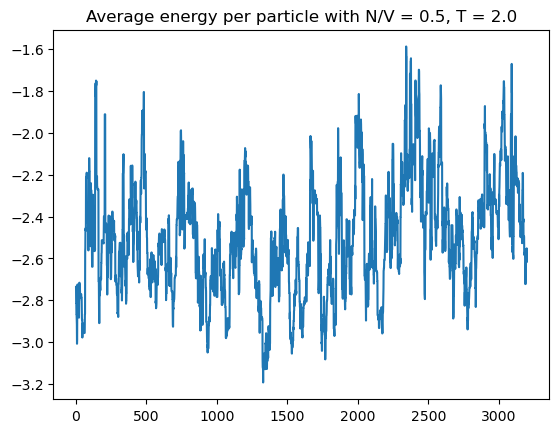

In [111]:
plt.plot(l_energies[3][1800:]/N[1])
plt.title("Average energy per particle with N/V = 0.5, T = 2.0")

# Low acceptance rate is expected for T = 0.5, and higher acceptance rate is expected for T = 2.

In [97]:
print(f"N/V = 0.7, T = 0.5: {a_rates[0]}")
print(f"N/V = 0.7, T = 2.0: {a_rates[1]}")
print(f"N/V = 0.5, T = 0.5: {a_rates[2]}")
print(f"N/V = 0.5, T = 2.0: {a_rates[3]}")

N/V = 0.7, T = 0.5: 0.0369
N/V = 0.7, T = 2.0: 0.4942
N/V = 0.5, T = 0.5: 0.0848
N/V = 0.5, T = 2.0: 0.6476


## Mean energy per particle N/V = 0.7, T = 0.5

In [102]:
print(np.average(l_energies[0])/N[0])

-4.247634074858754


## Mean energy per particle N/V = 0.7, T = 2.0

In [103]:
print(np.average(l_energies[1])/N[0])

-3.3962742348742068


## Mean energy per particle N/V = 0.5, T = 0.5

In [104]:
print(np.average(l_energies[2])/N[1])

-3.1219471915114974


## Mean energy per particle N/V = 0.5, T = 0.5

In [105]:
print(np.average(l_energies[3])/N[1])

-2.477135188962175


# Updated summary: My simulation can reliably approach equilibrium as well as prevent overlaps when initializing original configuration. It can provide insight on equilibrium times and behaviors at equilibrium for any given sigma and epsilon. Some limitations are tied to the fact that I do not have a tail correction implemented as I am unsure whether or not it is necessary or even useful, as well as N/V = 0.5 and T = 0.5 does not retain at least 20 independent samples from the 1D autocorrelation function. The same could be said about N/V 0.7 and T = 0.5, with having a weaker plot but still a reasonable average energy per particle. I only got a maximum of 13 samples here. Two takeaways: I learned how to use an autocorrelation function! I also realized how nice using the time module was for keeping track of simulation performance. The biggest takeaway is that I now feel like I have really made a dent in knowledge in how to write a Monte Carlo simulation.